## Map stations

In [33]:
import os
import zipfile
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import numpy as np
from pyproj import Proj
from osgeo import gdal

In [34]:
df = pd.read_csv('data/Estaciones_meteorologicas.csv')
df.head()

fuente  numero codigo                         nombre tipo   provincia  \
0  esta_inamhi       1  M0029                          BAÑOS   CP  TUNGURAHUA   
1  esta_inamhi       2  M0258                QUEROCHACA(UTA)   CP  TUNGURAHUA   
2  esta_inamhi       3  M1069  CALAMACA CONVENIO INAMHI HCPT   CP  TUNGURAHUA   
3  esta_inamhi       4  M0126                         PATATE   CO  TUNGURAHUA   
4  esta_inamhi       5  M0127                        PILLARO   CO  TUNGURAHUA   

        estado fecha_instalacion  latitud  longitud  \
0  FUNCIONANDO         20-jun-62  12329.0  782505.0   
1  FUNCIONANDO          2-nov-85  12202.0  783620.0   
2  FUNCIONANDO          4-jul-88  11634.0  784908.0   
3  FUNCIONANDO          1-may-63  11801.0  783000.0   
4  FUNCIONANDO          1-Dec-63  11010.0  783310.0   

                                 parametros_medicion  
0  Temperatura Max, temperatura Min, Temperatura,...  
1  Temperatura Max, temperatura Min, Temperatura,...  
2  Temperatura Max, temperatura Min, Temperatura,...  
3  Temperatura Max, temperatura Min, Temperatura,...  
4  Temperatura Max, temperatura Min, Temperatura,...

In [35]:
# Conversion from UTM to degrees
# https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
# EPSG:32717 (UTM 17S) (copy Proj4 format)
north = Proj("+proj=utm +zone=17 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
south = Proj("+proj=utm +zone=17 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['lon_deg'] = np.nan 
df['lat_deg'] = np.nan 

In [36]:
# Convert DMS coords to DD
def latDD(x):
    D = int(str(x)[0:1])
    M = int(str(x)[1:3])
    S = int(str(int(x))[3:])
    DD = -(D + float(M)/60 + float(S)/3600)
    return DD
def lonDD(x):
    D = int(str(x)[0:2])
    M = int(str(x)[2:4])
    S = int(str(int(x))[4:])
    DD = -(D + float(M)/60 + float(S)/3600)
    return DD

In [37]:
# UTM info : http://geokov.com/education/utm.aspx
# Northing coordinates use Equator as reference. For NH, Equator= 0. For SH , Equator = 10.000.000
# Easting coordinates use the false origin 500000 meters to the west of the central meridian of the UTM zone

# ESTA INAMHI data had lat = xxxS and long = xxxW 
## 17N
df.loc[df['fuente'] != 'esta_inamhi','lon_deg'], df.loc[df['fuente'] != 'esta_inamhi','lat_deg']= south(df[df['fuente'] != 'esta_inamhi']['longitud'].values, 
                                                df[df['fuente'] != 'esta_inamhi']['latitud'].values, inverse=True)

## 17S
df.loc[df['fuente'] == 'esta_inamhi','lon_deg'] =  [lonDD(x) for x in df[df['fuente'] == 'esta_inamhi']['longitud'].values]
df.loc[df['fuente'] == 'esta_inamhi','lat_deg']= [latDD(x) for x in df[df['fuente'] == 'esta_inamhi']['latitud'].values]
                                                
                               

In [38]:
df['lon_deg'] = df['lon_deg'].replace({float("inf"): np.nan})  
df['lat_deg'] = df['lat_deg'].replace({float("inf"): np.nan})

In [39]:
### use all stations
gdf_all = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lon_deg'], df['lat_deg']))

In [40]:
### take only selected stations
sel= df[(df.fuente == 'esta_hgpt') & (df.tipo== 'MA')]

In [41]:
gdf_sel = gpd.GeoDataFrame(
    sel, geometry=gpd.points_from_xy(sel['lon_deg'], sel['lat_deg']))

In [10]:
gdf = gdf.set_crs(epsg=4326)

In [ ]:
### Add contextual data to map
- Volcanoes
- DEM
- provinces
- cities
- Land use
 ### Source : Marc Souris savgis
## http://www.savgis.org/ecuador.htm province, volcanoes, cities
### https://www.diva-gis.org/datadown elevation, land use

### Contextual layers

In [12]:
### Más capas
### Volcanoes
zipfile ='zip:///Users/tamarahuete/Documents/Github_repos/TFM21/data/Map/volcanes.zip'
vol = gpd.read_file(zipfile)

## Provinces
zipfile ='zip:///Users/tamarahuete/Documents/Github_repos/TFM21/data/Map/provincias.zip'
prov = gpd.read_file(zipfile)

## Cities
zipfile ='zip:///Users/tamarahuete/Documents/Github_repos/TFM21/data/Map/ciudades.zip'
cit = gpd.read_file(zipfile)

In [13]:
tung = prov[prov['Id'] == '000020']
tung = tung.set_crs(epsg=4326)
vol = vol.set_crs(epsg=4326)
cit = cit.set_crs(epsg =4326)

In [14]:
vol_tung = gpd.clip(vol,tung)
cit_tung = gpd.clip(cit, tung)

<AxesSubplot:>

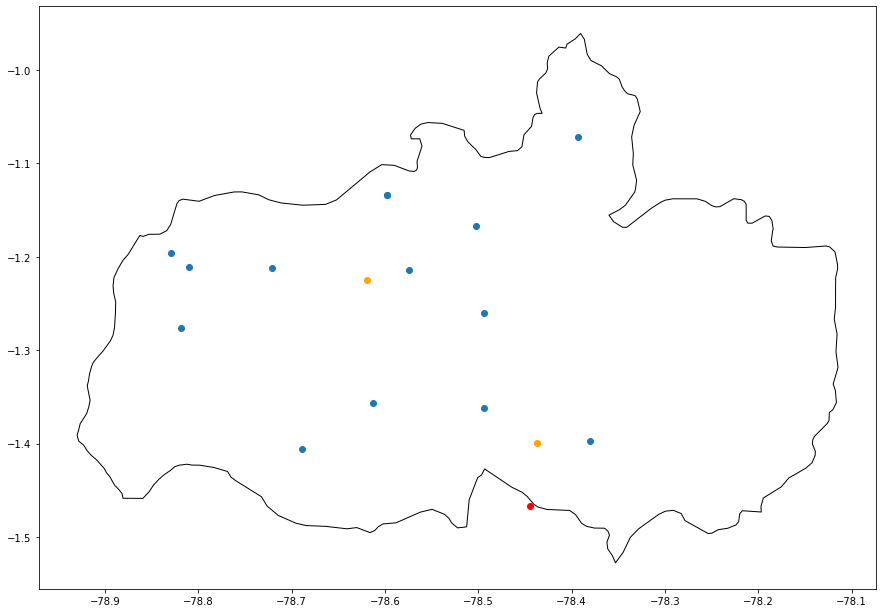

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#Ec.plot(ax=ax, color='white', edgecolor='black')
#prov.plot(ax=ax,color='white', edgecolor='black')
tung.plot(ax=ax, color='white', edgecolor='black', legend=True)
gdf4326.plot(ax=ax)
vol[vol['Id']== 'Volcán Tungurahua'].plot(ax=ax, color ='red')
cit_tung.plot(ax=ax, color = 'orange')

### DEM data

In [ ]:
####DEM data 
#https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/

In [29]:
import elevation
from osgeo import gdal

In [87]:
!eio clip -o Ecuador-30m-DEM.tif --bounds -78.8 -1.6 -78.2 -0.9

make: Entering directory '/Users/tamarahuete/Library/Caches/elevation/SRTM1'
curl -s -o spool/S02/S02W079.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/S02/S02W079.hgt.gz && mv spool/S02/S02W079.hgt.gz.temp spool/S02/S02W079.hgt.gz
gunzip spool/S02/S02W079.hgt.gz 2>/dev/null || touch spool/S02/S02W079.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/S02/S02W079.hgt cache/S02/S02W079.tif 2>/dev/null || touch cache/S02/S02W079.tif
curl -s -o spool/S01/S01W079.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/S01/S01W079.hgt.gz && mv spool/S01/S01W079.hgt.gz.temp spool/S01/S01W079.hgt.gz
gunzip spool/S01/S01W079.hgt.gz 2>/dev/null || touch spool/S01/S01W079.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/S01/S01W079.hgt cache/S01/S01W079.tif 2>/dev/null || touch cache/S01/S01W079.tif
rm spool/S01/S01W079.hgt spool/S02/S02W079.hgt
make: Leaving directory '/Users/tamarahuet

In [31]:
filename = "Ecuador-30m-DEM.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

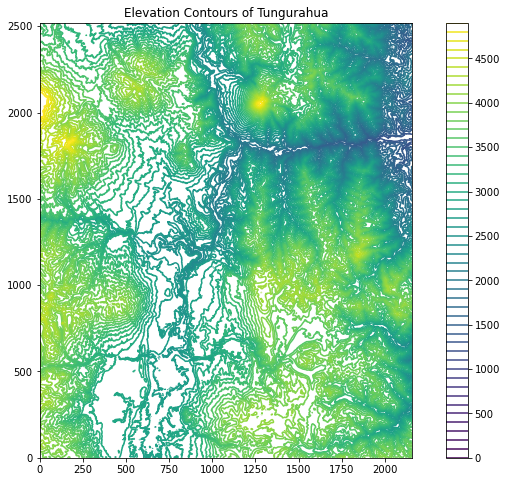

In [33]:
#Plot out data with Matplotlib's 'contour'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            levels = list(range(0, 5000, 100)))
plt.title("Elevation Contours of Tungurahua")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

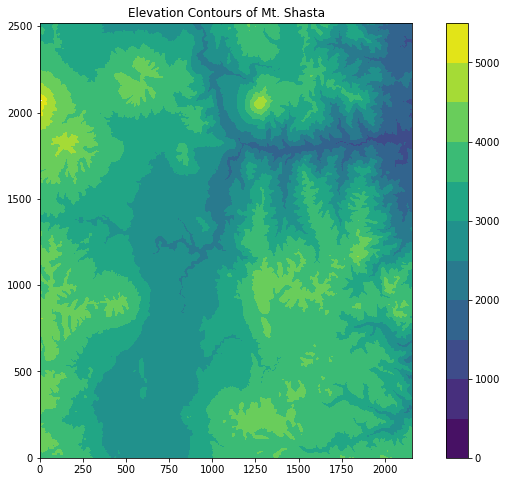

In [35]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = list(range(0, 6000, 500)))
plt.title("Elevation Contours of Mt. Shasta")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
### Add BAsemap to geopandas plot
#https://geopandas.org/gallery/plotting_basemap_background.html

In [17]:
import contextily as ctx

In [42]:
df = tung.to_crs(epsg =3857)
gdf_all = gdf_all.set_crs(epsg=4326)
gdf_sel = gdf_sel.set_crs(epsg=4326)

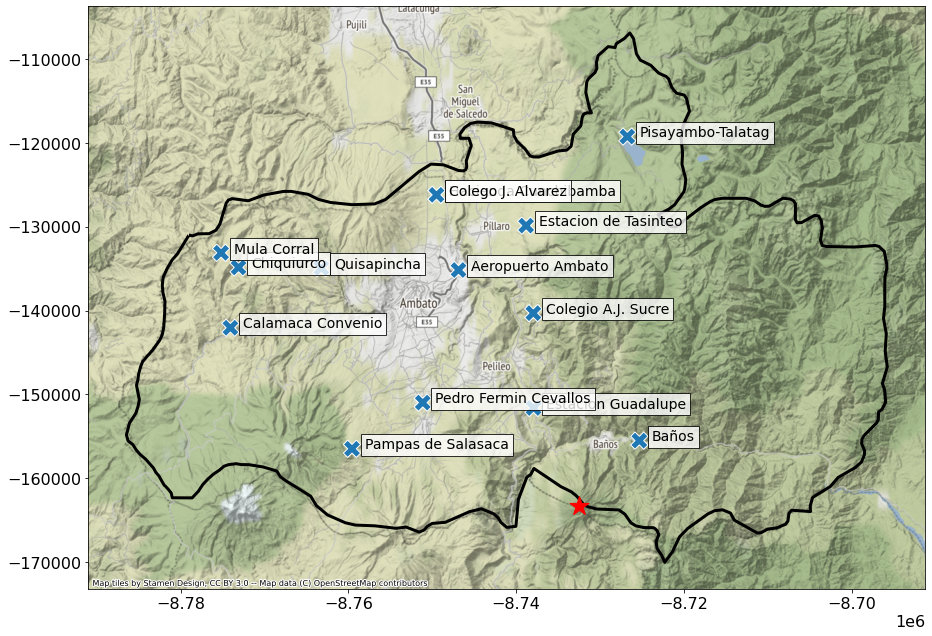

In [52]:
### Only HGPT stations

plt.rcParams.update({'font.size': 16})
ax = df.plot(figsize=(15, 15), edgecolor='black', color = "none", lw =3)
vol[vol['Id']== 'Volcán Tungurahua'].to_crs(epsg =3857).plot(ax=ax, color ='red', marker = "*", markersize = 400)
# cit_tung.to_crs(epsg =3857).plot(ax=ax, color = 'lightgray', marker = 'o', markersize=200, edgecolors = 'black')
gdf_sel.to_crs(epsg =3857).plot(ax=ax, column = 'tipo', marker="X", markersize = 300, edgecolors = 'white', legend = False) 
gdf3857 = gdf_sel.to_crs(epsg =3857)
for i in gdf3857.index.values:
    plt.text(x=gdf3857.geometry.x[i]+1500,y=gdf3857.geometry.y[i],s=gdf3857.nombre[i], 
          fontdict=dict(color='black',size=14),
          bbox=dict(facecolor='white',alpha=0.8))

ctx.add_basemap(ax)
plt.savefig(f'data/Map/map_hgpt_dem.png', dpi = 100,bbox_inches='tight')

In [50]:
gdf_all =gdf_all[~(gdf_all['nombre'].isin(['BAÑOS','CALAMACA CONVENIO INAMHI HCPT','PILLARO'])) & (gdf_all['fuente']!='esta_hgpt_sen')]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


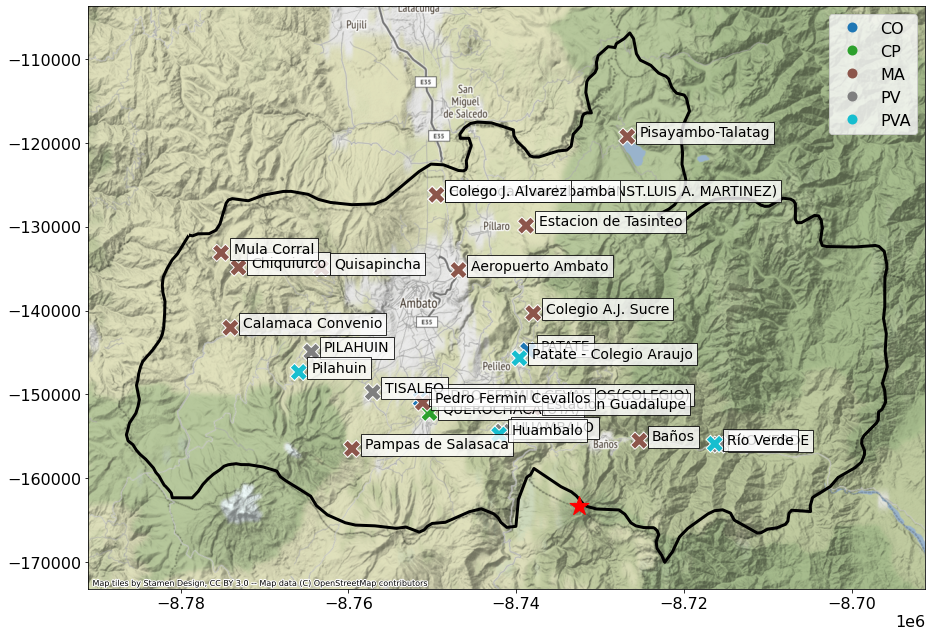

In [55]:
### All initila 27 stations stations

plt.rcParams.update({'font.size': 16})
ax = df.plot(figsize=(15, 15), edgecolor='black', color = "none", lw =3)
vol[vol['Id']== 'Volcán Tungurahua'].to_crs(epsg =3857).plot(ax=ax, color ='red', marker = "*", markersize = 400)
# cit_tung.to_crs(epsg =3857).plot(ax=ax, color = 'lightgray', marker = 'o', markersize=200, edgecolors = 'black')
gdf_all.to_crs(epsg =3857).plot(ax=ax, column = 'tipo', marker="X", markersize = 300, edgecolors = 'white', legend = True) 
gdf3857 = gdf_all.to_crs(epsg =3857)
for i in gdf3857.index.values:
    plt.text(x=gdf3857.geometry.x[i]+1500,y=gdf3857.geometry.y[i],s=gdf3857.nombre[i], 
          fontdict=dict(color='black',size=14),
          bbox=dict(facecolor='white',alpha=0.8))

ctx.add_basemap(ax)
plt.savefig(f'data/Map/map_all_dem_type.png', dpi = 100,bbox_inches='tight')

### División por Valle y Temp

In [59]:
gdf_sel['valle'] =['Ambato','Patate','Cutuchi','Cutuchi','Patate','Pastaza','Cutuchi','Ambato','Ambato','Ambato','Ambato','Ambato','Cutuchi','Cutuchi']
gdf_sel['temp'] =['Baja','Media','Media','Media','Alta','Alta','Media','Media','Baja','Baja','Baja','Baja','Baja','Baja']

In [61]:
gdf_sel[['nombre','valle','temp']]

nombre    valle   temp
11             Chiquiurco   Ambato   Baja
12     Colegio A.J. Sucre   Patate  Media
13   Hacienda Cunchibamba  Cutuchi  Media
14      Colego J. Alvarez  Cutuchi  Media
15     Estacion Guadalupe   Patate   Alta
16                  Baños  Pastaza   Alta
17      Aeropuerto Ambato  Cutuchi  Media
18  Pedro Fermin Cevallos   Ambato  Media
19      Calamaca Convenio   Ambato   Baja
20            Mula Corral   Ambato   Baja
21            Quisapincha   Ambato   Baja
22     Pampas de Salasaca   Ambato   Baja
23   Estacion de Tasinteo  Cutuchi   Baja
24      Pisayambo-Talatag  Cutuchi   Baja

In [ ]:
### Plot temperature
 # View corrected values
colors = ['#fcca43','#fd8807','#fa0811']
model_color = dict(zip(temp,colors))

fig, axes = plt.subplots(2,1,figsize= (10,10))
for a in range(0,len(temp)):
    df[temp[a]][:480].plot(ax = axes[0],color = model_color[temp[a]])
    df[rh[a]][:480].plot(ax = axes[1],color = model_color[temp[a]])
    axes[0].legend()
plt.savefig(f'{path}/{cuenca}_temp_rh.png', dpi = 100,bbox_inches='tight')

In [72]:
colors= ['#fcca43','#fd8807','#fa0811']
tcol= dict(zip(['Baja','Media','Alta'],colors))

colors= ['#f8b140','#a65c74','#2fb479','#526daa']
vcol= dict(zip(['Ambato','Cutuchi','Pastaza','Patate'],colors))


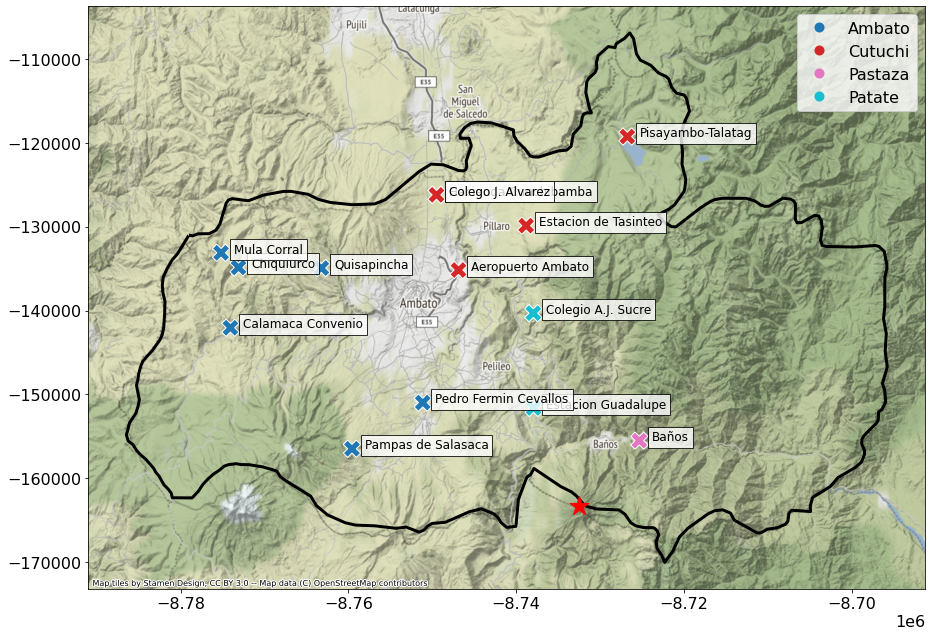

In [74]:
### Valle
plt.rcParams.update({'font.size': 16})
ax = df.plot(figsize=(15, 15), edgecolor='black', color = "none", lw =3)
vol[vol['Id']== 'Volcán Tungurahua'].to_crs(epsg =3857).plot(ax=ax, color ='red', marker = "*", markersize = 400)
# cit_tung.to_crs(epsg =3857).plot(ax=ax, color = 'lightgray', marker = 'o', markersize=200, edgecolors = 'black')
gdf_sel.to_crs(epsg =3857).plot(ax=ax, column = 'valle', marker="X", markersize = 300, edgecolors = 'white', legend = True) 
gdf3857 = gdf_sel.to_crs(epsg =3857)
for i in gdf3857.index.values:
    plt.text(x=gdf3857.geometry.x[i]+1500,y=gdf3857.geometry.y[i],s=gdf3857.nombre[i], 
          fontdict=dict(color='black',size=12),
          bbox=dict(facecolor='white',alpha=0.8))

ctx.add_basemap(ax)
plt.savefig(f'data/Map/map_hgpt_dem_valle.png', dpi = 100,bbox_inches='tight')

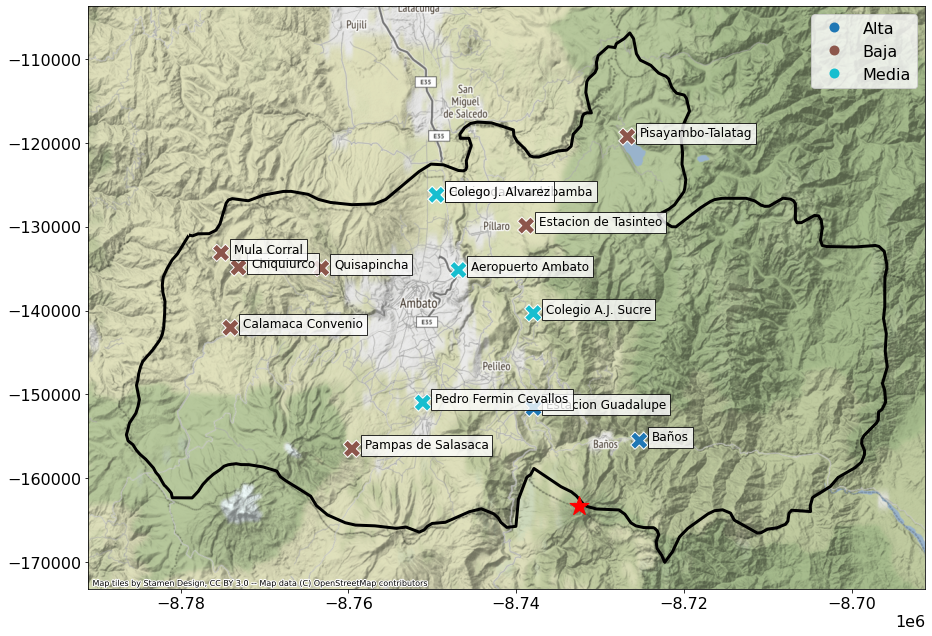

In [79]:
### Temp
plt.rcParams.update({'font.size': 16})
ax = df.plot(figsize=(15, 15), edgecolor='black', color = "none", lw =3)
vol[vol['Id']== 'Volcán Tungurahua'].to_crs(epsg =3857).plot(ax=ax, color ='red', marker = "*", markersize = 400)
# cit_tung.to_crs(epsg =3857).plot(ax=ax, color = 'lightgray', marker = 'o', markersize=200, edgecolors = 'black')
gdf_sel.to_crs(epsg =3857).plot(ax=ax, column = 'temp', marker="X", markersize = 300, edgecolors = 'white', legend = True) 
gdf3857 = gdf_sel.to_crs(epsg =3857)
for i in gdf3857.index.values:
    plt.text(x=gdf3857.geometry.x[i]+1500,y=gdf3857.geometry.y[i],s=gdf3857.nombre[i], 
          fontdict=dict(color='black',size=12),
          bbox=dict(facecolor='white',alpha=0.8))
ctx.add_basemap(ax)
plt.savefig(f'data/Map/map_hgpt_dem_temp.png', dpi = 100,bbox_inches='tight')